# Less pain, more gain, lift weights with your AI trainer.

Analyzing your pose while you lift weights is a great way to improve your form and prevent injury. In this notebook, we'll show you how to analyze your posture in real-time, using a webcam.

In [1]:
%cd ..
from ai_trainer.models import BlazePoseModel

BLAZEPOSE_MODEL_PATH = "./models/blazepose_full.onnx"

blazepose_model = BlazePoseModel(model_path=BLAZEPOSE_MODEL_PATH)

/home/teresa/GitLab/ai-trainer


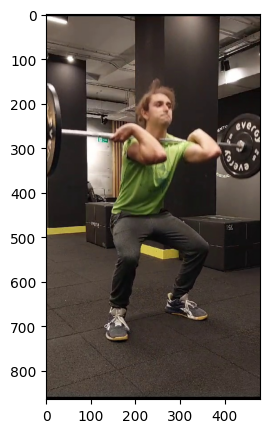

In [2]:
import matplotlib.pyplot as plt
import cv2

IMAGE_PATH = "./assets/500_perfect.jpg"  # change if needed

# read image
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot image
plt.figure(1, figsize=(5, 5))
plt.imshow(image)

### Estimate Pose

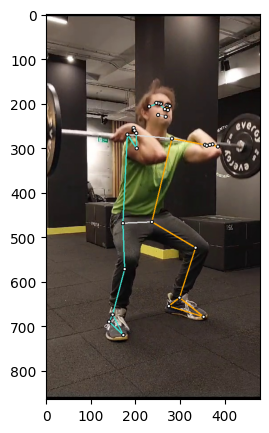

In [3]:
import numpy as np
from ai_trainer.drawing import draw_pose

# copy image to plot on it
plot_image = image.copy()
img_h, img_w = image.shape[:2]

kps = blazepose_model.predict([image])[0]  # batch size is 1
probs = kps.T[3]

if not any(probs<-1):
    # plot keypoints on image
    # denormalize keypoints to pixel values
    x, y = kps.T[:2]
    x_img = x * img_w
    y_img = y * img_h
    pose = np.column_stack((x_img, y_img))
    plot_image = draw_pose(
        image=plot_image,
        keypoints=pose,
        disposition="mediapipe", # blazepose keypoints are in mediapipe format
        thickness=2,
    )

# plot image
plt.figure(figsize=(5, 5))
plt.imshow(plot_image)

## Define heuristics

**Front squad:**

While the front squat is primarily a “leg exercise,” your upper body is thoroughly involved in the movement. Your shoulders, arms, and back must coordinate to support the barbell and stabilize the weight during each repetition. A misstep with any of these key body parts will lead to an inefficient, and potentially dangerous, performance. Here’s what to watch for.

1. Barbell should rest between your anterior deltoids (front shoulder muscles) and your clavicles (collarbones).
2. Use a full grip (all the fingers around the bar). If you’re not in a competition, you can take off one or two fingers to alleviate the wrist pressure and reduce the wrist and elbow mobility requirement.
3. keep your elbows as high as possible. Keeping your elbows up will ensure your upper back remains in a strong position and helps to prevent your back from rounding forward.
4. Don’t Let Your Upper Back Round.
5. Don’t Let Your Heels Raise Off the Floor.
6. Beware of Knee Caving. Your knees should remain in line with your toes during the exercise, but excessive valgus (when your knees come toward each other) can happen, especially as you go deeper. This results in your knees caving inwards and stress shifting away from your legs muscles and onto your knee stabilizers.
7. Set your feet at width, approximately between your hips and shoulders
8. Go down. Bend simultaneously your hips and knees under your thighs are approximately parallel the ground.


What will we target?
1. Elbows position. must point upwards, not downwards.
2. You must look forward, not down. <-- NOT POSSIBLE?
3. Tight grip, not loose <-- NOT POSSIBLE
4. Knees aligned with toes, not caving inwards.
5. Feet at width, not too wide or too narrow.

In [4]:
#denormalize keypoints
x, y, z = kps.T[:3]
x_img = x * img_w
y_img = y * img_h
pose_3d = np.column_stack((x_img, y_img, z))

### Are the elbows pointing downwards?

In [6]:
from ai_trainer.feedback.front_squat import are_elbows_down

#if is_any_elbow_lower_than_shoulders(kps):
if are_elbows_down(pose_3d):
    print("Rise your elbows!!!")
else:
    print("keep it up! Great job!")

keep it up! Great job!


### Are you looking down or straight?

In [7]:
import math

def is_looking_down(kps):
    right_eye = (kps[1] + kps[2] + kps[3])/3
    right_ear = kps[7]

    left_eye = (kps[4] + kps[5] + kps[6])/3
    left_ear = kps[8]
    
    avg_eye_x, avg_eye_y = ((right_eye + left_eye)/2)[:2]
    avg_ear_x, avg_ear_y = ((right_ear + left_ear)/2)[:2]

    # Calculate the angle using the arctangent function
    angle_radians = math.atan2(avg_eye_y - avg_ear_y, avg_eye_x - avg_ear_x)
    angle_degrees = math.degrees(angle_radians)

    return np.abs(angle_degrees) > 40

In [8]:
if is_looking_down(pose_3d):
    print("Look forward!!!")
else:
    print("keep it up! Great job!")

keep it up! Great job!


### Be aware of knee caving

In [9]:
from ai_trainer.feedback.front_squat import are_knees_bending, are_knees_caving

if are_knees_bending(pose_3d):
    if are_knees_caving(pose_3d):
        print("Open your knees!!!")
    else:
        print("keep it up! Great job!")

keep it up! Great job!


### Keep your feet at shoulder width

In [10]:
from ai_trainer.feedback.front_squat import (is_in_start_position,
                                             are_feet_well_positioned)

if is_in_start_position(pose_3d):
    if are_feet_well_positioned(pose_3d):
        print("keep it up! Great job!")
    else:
        print("Your feet should be at shoulder width!!!")

### track that the bar follows a straight vertical line

## complete tests

In [11]:
def give_feedback(kps):
    feedback = {'is_in_position': False}
    if is_in_start_position(kps):
        feedback['is_in_position'] = True
        if not are_feet_well_positioned(kps):
            feedback['feet_position'] = "Your feet should be at shoulder width!!!"
        if are_elbows_down(kps):
            feedback['elbow_position'] = "Rise your elbows!!!"
        if are_knees_bending(kps):
            if are_knees_caving(kps):
                feedback["knee_position"] = "Open your knees!!!"
    return feedback

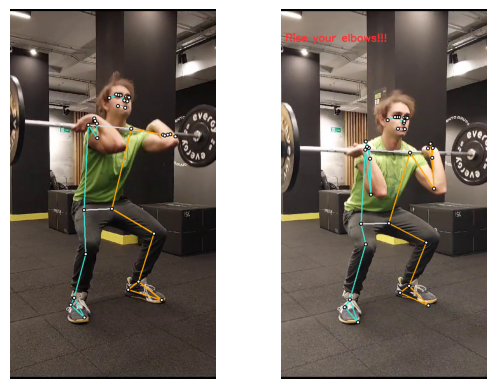

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from ai_trainer.models import BlazePoseModel
from ai_trainer.drawing import draw_pose, draw_text
from ai_trainer.feedback.front_squat import give_feedback

BLAZEPOSE_MODEL_PATH = "./models/blazepose_full.onnx"
blazepose_model = BlazePoseModel(model_path=BLAZEPOSE_MODEL_PATH)

SAMPLE_PATH_1 = "./assets/500_perfect.jpg"
SAMPLE_PATH_2 = "./assets/715_low_elbows.jpg"

sample_1 = cv2.imread(SAMPLE_PATH_1)
sample_2 = cv2.imread(SAMPLE_PATH_2)
samples = [ cv2.cvtColor(sample_1, cv2.COLOR_BGR2RGB),
		cv2.cvtColor(sample_2, cv2.COLOR_BGR2RGB)]

f, axarr = plt.subplots(1,2)
for i, sample in enumerate(samples):
    img_h, img_w = sample.shape[:2]
    kps = blazepose_model.predict([sample])[0]  # batch size is 1

    probs = kps.T[3]
    if not any(probs<0):
        # denormalize keypoints:
        x, y, z = kps.T[:3]
        x_img = x * img_w
        y_img = y * img_h
        pose_3d = np.column_stack((x_img, y_img, z))
        pose_2d = np.column_stack((x_img, y_img))
        
        # plot keypoints on image
        sample = draw_pose(
            image=sample,
            keypoints=pose_2d,
            disposition="mediapipe", # blazepose keypoints are in mediapipe format
            thickness=2,
        )

        feedback, possible_corrections = give_feedback(pose_3d)
        number_corrections = len(list(feedback.keys())[1::])

        y_text_pos = 0
        for correction in possible_corrections:
            y_text_pos+=25
            if correction in list(feedback.keys()):
                sample = draw_text(
                    image=sample,
                    text=feedback[correction],
                    origin=(10, y_text_pos),
                    font_scale=0.8,
                    color=(250, 50, 50),
                    thickness=2,
                )
        
    axarr[i].imshow(sample)
    axarr[i].axis('off')

# Try it on a video

In [7]:
import cv2
import numpy as np
from tqdm import tqdm

from ai_trainer.models import BlazePoseModel
from ai_trainer.drawing import draw_pose, draw_text
from ai_trainer.feedback.front_squat import give_feedback

In [8]:
VIDEO_PATH = "./assets/left_side_cut.mp4"
SAVE_VIDEO_PATH = VIDEO_PATH[:-4] + "_processed.mp4"

BLAZEPOSE_MODEL_PATH = "./models/blazepose_full.onnx"
blazepose_model = BlazePoseModel(model_path=BLAZEPOSE_MODEL_PATH)

barbell_position = []
# Read video:
cap = cv2.VideoCapture(VIDEO_PATH)
if cap.isOpened() is False:
    print("Error reading the video file")

# Get video configuration
nbr_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_size = int(cap.get(3)), int(cap.get(4))  # frame_w, frame_h
img_w, img_h = frame_size
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Create video writer
# Get video codec
if VIDEO_PATH[-4:] == ".mp4" or VIDEO_PATH[-4:] == ".MOV":
    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
elif VIDEO_PATH[-4:] == ".avi":
    fourcc = cv2.VideoWriter_fourcc(*"XVID")

output = cv2.VideoWriter(SAVE_VIDEO_PATH,
                        fourcc,
                        fps, frame_size)

# Iterate through frames
for i in tqdm(range(int(nbr_frames))):
    # Read the video file
    ret, frame = cap.read()

    # Check we have frames:
    if frame is None:
        break
    copy_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
    kps = blazepose_model.predict([copy_frame])[0]  # batch size is 1

    probs = kps.T[3]
    if not any(probs<0):
        # denormalize keypoints:
        x, y, z = kps.T[:3]
        x_img = x * img_w
        y_img = y * img_h
        pose_3d = np.column_stack((x_img, y_img, z))
        pose_2d = np.column_stack((x_img, y_img))
        barbell_position.append((pose_3d[15] + pose_3d[16])/2)
        # plot keypoints on image
        copy_frame = draw_pose(
            image=copy_frame,
            keypoints=pose_2d,
            disposition="mediapipe", # blazepose keypoints are in mediapipe format
            thickness=2,
        )

        feedback, possible_corrections = give_feedback(pose_3d)

        y_text_pos = 0
        for correction in possible_corrections:
            y_text_pos+=25
            if correction in list(feedback.keys()):
                copy_frame = draw_text(
                    image=copy_frame,
                    text=feedback[correction],
                    origin=(10, y_text_pos),
                    font_scale=0.8,
                    color=(250, 50, 50),
                    thickness=2,
                )
    output.write(copy_frame)

cap.release()
output.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████| 1428/1428 [00:50<00:00, 28.39it/s]


## Looking at the barbell position in time

Text(0.5, 1.0, 'Barbell position in time')

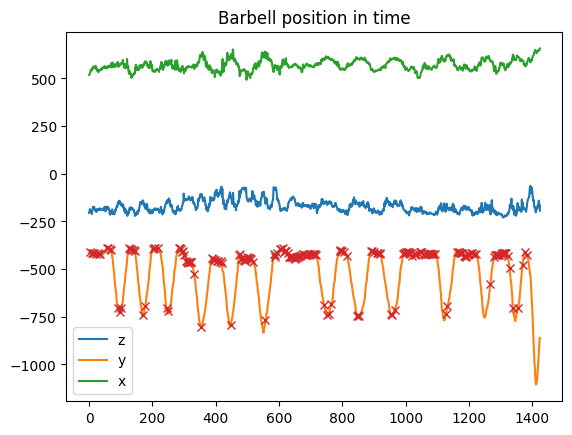

In [41]:
from scipy.signal import find_peaks

time = np.arange(0, len(barbell_position), 1)
# plot y position in time
plt.plot(z)
plt.plot(-y)
plt.plot(x)
#add legend
plt.legend(["z", "y", "x"])
plt.plot(time[peaks], -y[peaks] , 'x')
#title
plt.title("Barbell position in time")